# Approaches for Removing Background

In [5]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage import filters
import skimage
import matplotlib.pyplot as plt
# import rembg

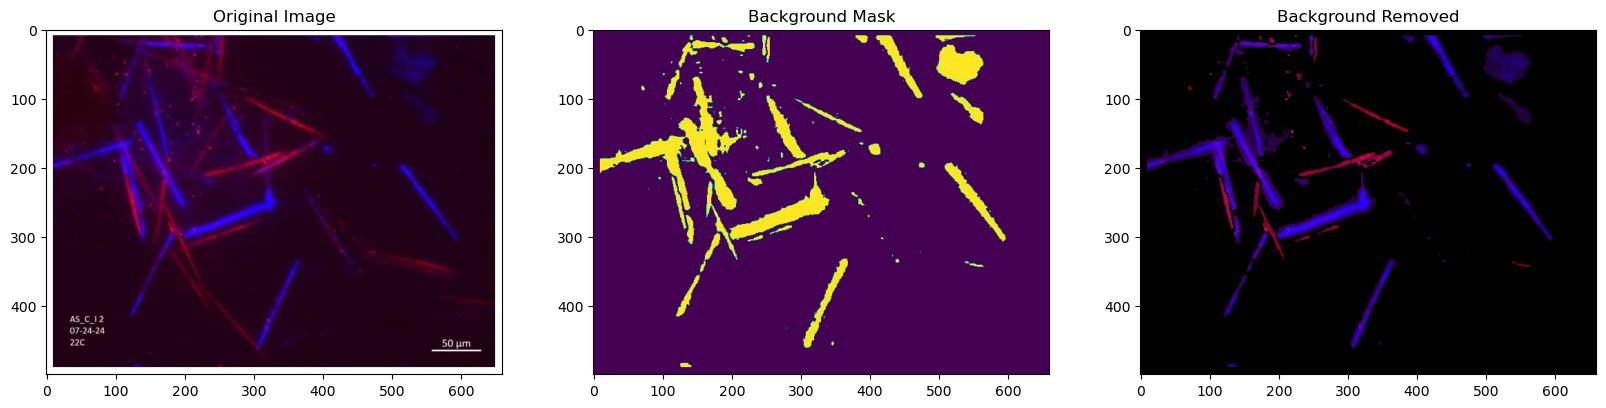

In [60]:
# Color Thresholding: HSV

# 1. Read image in RGB format
image_og = cv2.imread("../data/images/ClumpyLate_AS_C_I_22_2_20240724.jpg") # og image
image = cv2.imread("../data/images/RedNormalizedImages/REDClumpyLate_AS_C_I_22_2_20240724.jpg") # red normalized
# image_og = cv2.imread("../images/ClumpyLate_AS_C_I_22_2_20240724.jpg") # og image
# image = cv2.imread("../images/RedNormalizedImages/REDClumpyLate_AS_C_I_22_2_20240724.jpg") # red normalized
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 2. Convert image to HSV color space (better for thresholding colors)
hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

# 3. Define color thresholds for red and blue ranges
# Red range
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])
mask_red1 = cv2.inRange(hsv, lower_red, upper_red)

lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Blue range
lower_blue = np.array([100, 50, 50])
upper_blue = np.array([140, 255, 255])
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

# 4. Combine red masks and blue mask
mask = mask_red1 | mask_red2 | mask_blue

# 5. Apply the mask to remove background
result = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# 6. Plot original and background-removed images
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title('Background Mask')
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title('Background Removed')
plt.show()


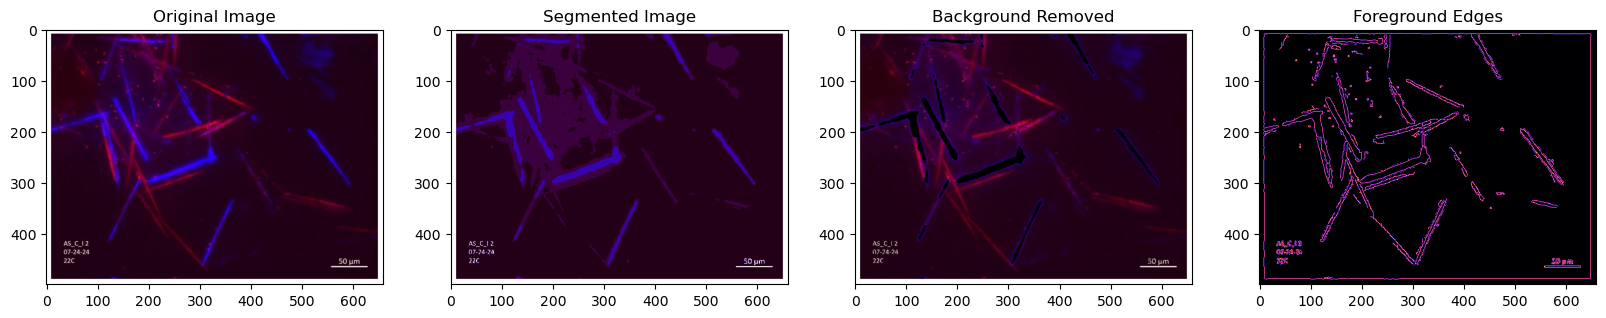

In [61]:
# K-means clustering--Decent
    # runs best on red-normalized
# 1. Read in images (above)

# 2. Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape((-1, 3))

# 3. Apply K-means clustering
pixels = np.float32(pixels)
k = 4  # Number of clusters (background + red + blue)
    # INTERESTINGLY, INCREASING TO 4 CLUSTERS IMPROVES BG ACCURACY
# set iterations and accuracy break points
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
# perform clustering with 10 attempts
_, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# 4. Convert cluster centers to integers
centers = np.uint8(centers)

# 5. Reconstruct image from the clustered labels and centers
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape(image_rgb.shape)

# 6. Create a mask by keeping only the clusters corresponding to red and blue
    # assume the background is the darkest cluster (cluster 0)
background_cluster = 0
mask = labels.reshape(image_rgb.shape[:2]) != background_cluster

# 7. Apply mask to keep only foreground clusters
foreground = np.zeros_like(image_rgb)
foreground[mask] = image_rgb[mask]

# 8. see how Canny edge detection performs
edges_rgb = cv2.Canny(foreground, threshold1=50, threshold2=150, apertureSize=3, L2gradient=False)

# Plot original and background-removed images
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(segmented_image, cmap='magma')
plt.title('Segmented Image')
plt.subplot(1, 4, 3)
plt.imshow(foreground)
plt.title('Background Removed')
plt.subplot(1, 4, 4)
plt.imshow(edges_rgb, cmap='magma')
plt.title('Foreground Edges')
plt.show()


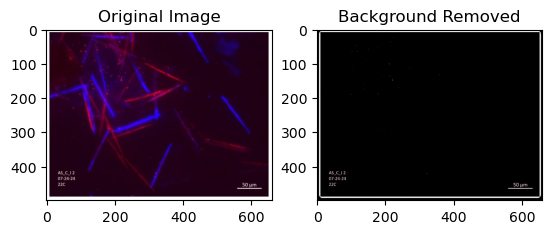

In [33]:
# 1. Read image in RGB format
# image = cv2.imread('your_image.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 2. Apply Gaussian blur to create a smooth background
blurred_image = cv2.GaussianBlur(image_rgb, (21, 21), 0)

# 3. Subtract the blurred image (background) from the original
background_removed = cv2.subtract(image_rgb, blurred_image) # THIS is the faulty step

# 4. Apply a threshold to emphasize bright regions
gray = cv2.cvtColor(background_removed, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

# 5. Use mask to keep bright red and blue regions
final_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# 6. Plot original and background-removed images
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title('Background Removed')
plt.show()


# DYSFUNCTIONAL APPROACHES

## bg-removal options include rembg, Pillow, OpenCV

In [2]:
# rembg approach

import rembg # error: OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
from rembg import remove 

# Load the image
input_path = 'input.png'
output_path = 'output.png'

# Remove the background
output = rembg.remove(input_path)

# Save the output
output.save(output_path)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


ValueError: Input type <class 'str'> is not supported. Try using force_return_bytes=True to force python bytes output

In [5]:
# Pillow approach
import numpy as np
from PIL import Image

# Load the image
image = cv2.imread("../images/ClumpyLate_AS_C_I_22_2_20240724.jpg")

# Convert to RGBA (with alpha channel)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

data = np.array(image_rgb)
# just use the rgb values for comparison
rgb = data[:,:,:3]
color = [246, 213, 139]   # Original value
black = [0,0,0, 255]
white = [255,255,255,255]
mask = np.all(rgb == color, axis = -1)
# change all pixels that match color to white
data[mask] = white
new_im = Image.fromarray(data)


# image = image.convert('RGBA')

# Separate the foreground and background
# fg = image.split()[0]  # Get the foreground channel
# bg = image.split()[3]  # Get the alpha channel (background)

# Invert the alpha channel to remove the background
# bg = 255 - bg

# Merge the foreground and inverted alpha channels
# no_bg = Image.merge('RGBA', (fg, fg, fg, bg))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Basic Edge Detection")
ax[0].imshow(image)
ax[1].imshow(new_im) # , cmap='magma'
    # set the title to all subplots
ax[0].set_title("RGB Image")
ax[1].set_title("BG Removal")
    # adjust spacing
fig.tight_layout()

# Save the output
# img.save('output.png')

ValueError: shape mismatch: value array of shape (4,) could not be broadcast to indexing result of shape (0,3)

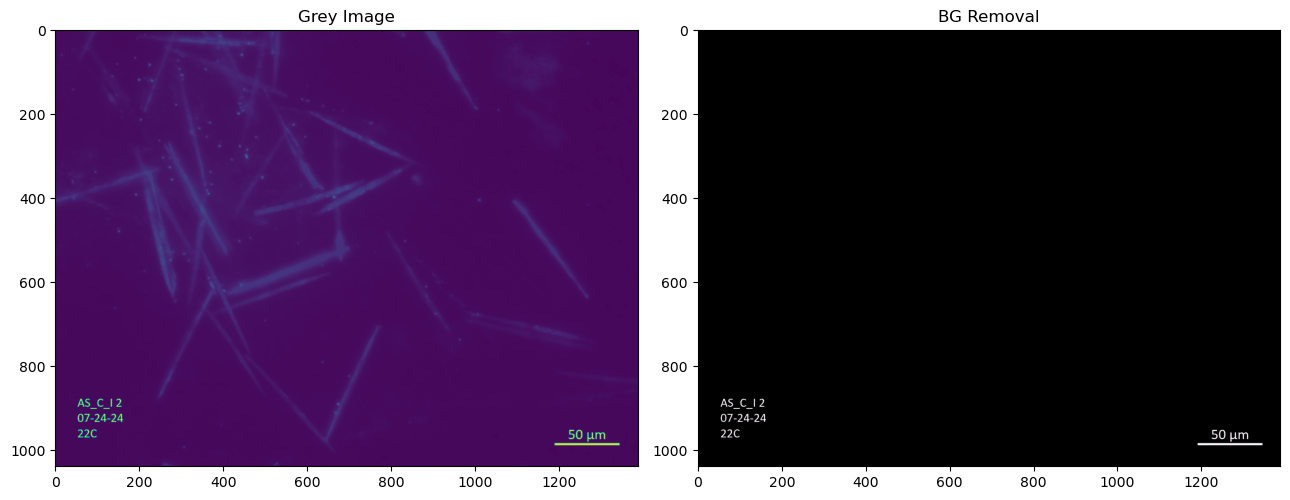

In [8]:
# OpenCV approach--FAILED bg detection via mask

# Load the image
image = cv2.imread("../images/ClumpyLate_AS_C_I_22_2_20240724.jpg")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply background subtraction (e.g., using a simple thresholding approach)
_, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Invert the mask to remove the background
mask = 255 - mask

# Apply the mask to the original image
output = cv2.bitwise_and(image, image, mask=mask)

# Save the output
# cv2.imshow("No BG", output)
# cv2.imwrite('output.png', output)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Basic Edge Detection")
ax[0].imshow(gray)
ax[1].imshow(output) # , cmap='magma'
    # set the title to all subplots
ax[0].set_title("Grey Image")
ax[1].set_title("BG Removal")
    # adjust spacing
fig.tight_layout()

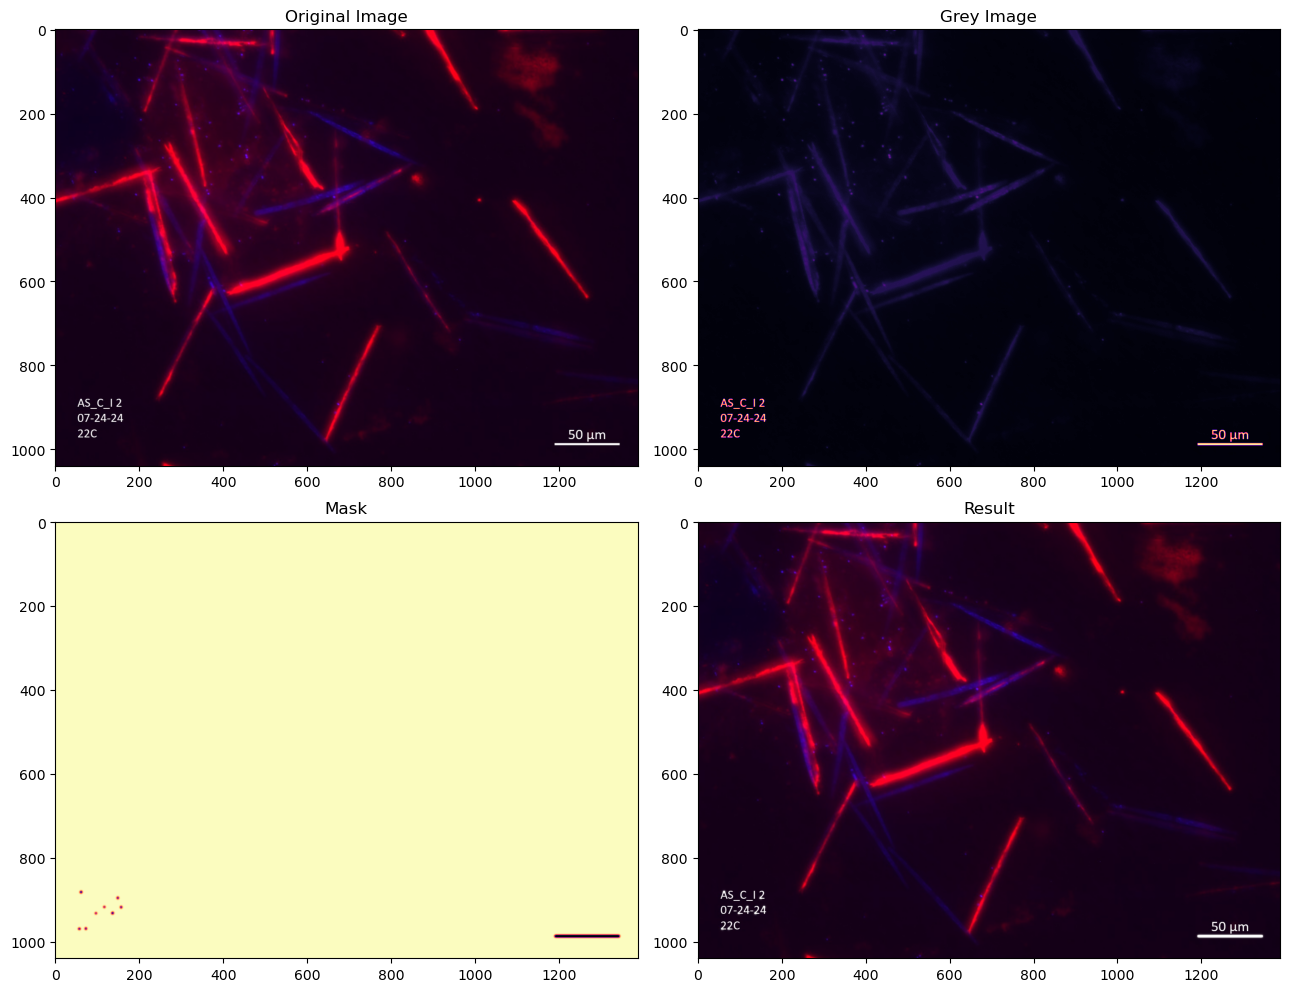

In [12]:
# OpenCV take 2

# load image
image = cv2.imread("../images/ClumpyLate_AS_C_I_22_2_20240724.jpg")

# convert to graky
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
# use borderconstant of black since foreground touches the edges
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = image.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# save resulting masked image
# cv2.imwrite('person_transp_bckgrnd.png', result)

# display result, though it won't show transparency
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(13, 10))
ax[0, 0].imshow(image, cmap='magma')
ax[0, 1].imshow(gray, cmap='magma')
ax[1, 0].imshow(mask, cmap='magma')
ax[1, 1].imshow(result, cmap='magma')
    # set the title to all subplots
ax[0, 0].set_title("Original Image")
ax[0, 1].set_title("Grey Image")
ax[1, 0].set_title("Mask")
ax[1, 1].set_title("Result")
    # adjust spacing
fig.tight_layout()


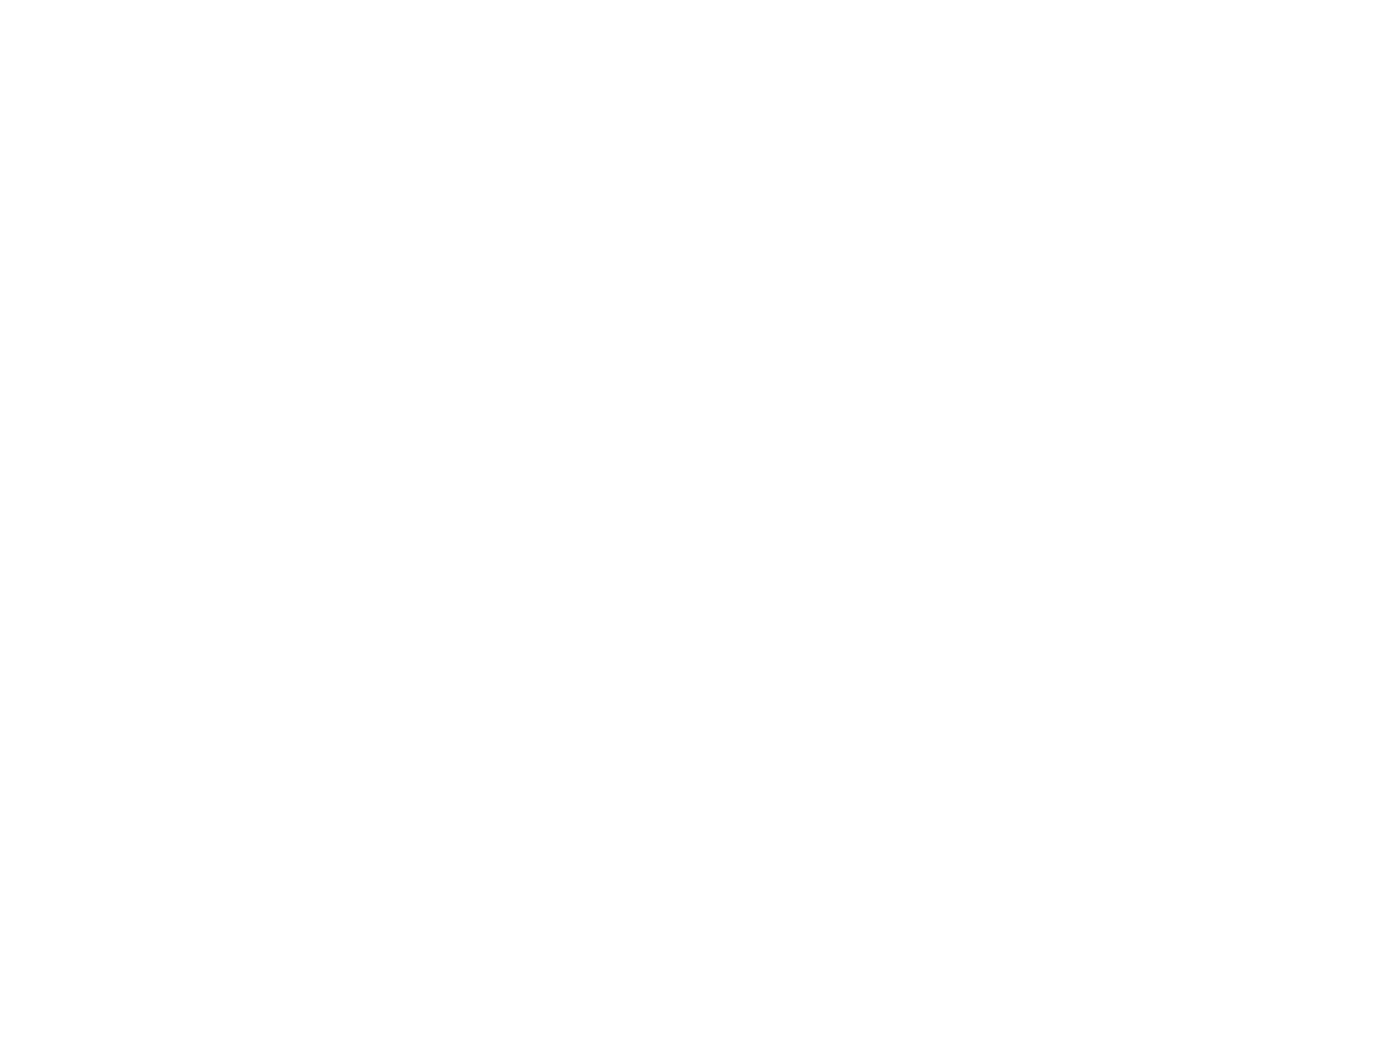

In [1]:
# Invert LUT approach

import numpy as np
from PIL import Image

def invert_image_lut(image_path):
    # Load the image using Pillow
    img = Image.open(image_path)
    
    # Convert to 8-bit grayscale
    gray_img = img.convert('L') # my addition

    # Convert the image to a NumPy array
    img_array = np.array(img) # this is repeating patterns

    # Create a LUT for inverting pixel values--THIS STEP CREATES A HOMOGENOUS ARRAY
    lut = np.zeros((256,), dtype=np.uint8)  # assuming 8-bit grayscale image
    lut[:] = 255 - lut[:]  # invert each pixel value

    # Apply the LUT to the image array
    inverted_img_array = np.take(lut, gray_img)

    # Convert the inverted image array back to a Pillow image
    inverted_img = Image.fromarray(inverted_img_array) # THIS IS JUST WHITE..?

    # return inverted_img
    return inverted_img

image_path = "../images/ClumpyLate_AS_C_I_22_2_20240724.jpg"
invert_image_lut(image_path)